In [9]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from itertools import product
import torch.nn.functional as F
import pandas as pd

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympde/misc'))

from run import parse_options, main
from tb_analysis import get_data, get_metrics, get_results
from utils import get_dict_item
from model.networks.linear import CalculatedP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
args = parse_options(notebook=True)

args.net = 'Predict-NoneP'
args.data_dir = '../data/flower'
args.data_kwargs = {'space_length':4**2, 'noise_std':0.0, 'y_low':0, 'y_high':3}

# args.do_return = True
# args.persistent_workers = False
# args.num_workers = 0

args.max_epochs = 30

args.train = True
args.test = False
# args.version = 'version_0'
args.predict = True

model, trainer, datamodule, preds = main(args)


{'space_length': 16.0, 'noise_std': 0.0, 'y_low': 0.0, 'y_high': 3.0}


In [5]:
x, y, eps = batch = next(iter(datamodule.train_dataloader()))

In [6]:
model(batch)

(tensor([0., 0.]), tensor([0., 0.], grad_fn=<SqueezeBackward1>))

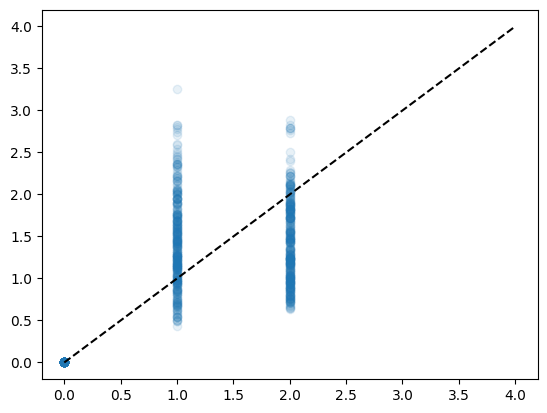

In [7]:
def stack_preds(preds):
    y_trues, y_preds = zip(*preds)
    return torch.cat(y_trues), torch.cat(y_preds)

y_trues, y_preds = stack_preds(preds)

y_trues.shape, y_preds.shape

mse_loss = F.mse_loss(y_preds, y_trues)
mse_loss.item()

l = 4
plt.plot(y_trues, y_preds, 'o', alpha = 0.1)
plt.plot([0, l], [0,l], 'k--')
plt.show()

# Run_twice

Seed set to 1




###	Version:  version_0 	###
###	Name:  symlieflat_dataflat_netTrainP_lr-1.00_seed1 	###


Loaded model from ../logs/symlieflat_dataflat_netTrainP_lr-1.00_seed1/version_0/checkpoints


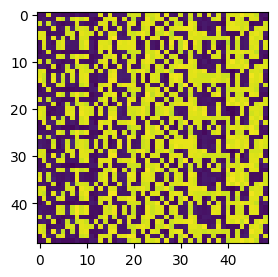

Seed set to 2




###	Version:  version_0 	###
###	Name:  symlieflat_dataflat_netTrainP_lr-1.00_seed2 	###


Loaded model from ../logs/symlieflat_dataflat_netTrainP_lr-1.00_seed2/version_0/checkpoints


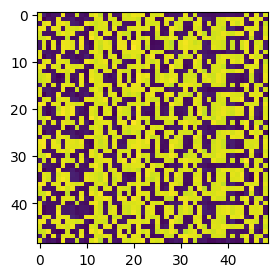

Seed set to 3




###	Version:  version_0 	###
###	Name:  symlieflat_dataflat_netTrainP_lr-1.00_seed3 	###


Loaded model from ../logs/symlieflat_dataflat_netTrainP_lr-1.00_seed3/version_0/checkpoints


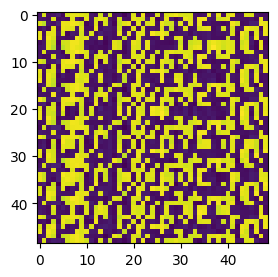

Seed set to 4




###	Version:  version_0 	###
###	Name:  symlieflat_dataflat_netTrainP_lr-1.00_seed4 	###


Loaded model from ../logs/symlieflat_dataflat_netTrainP_lr-1.00_seed4/version_0/checkpoints


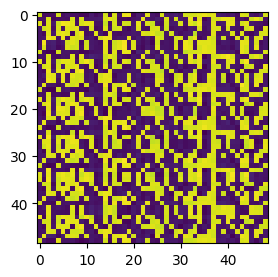

Seed set to 5




###	Version:  version_0 	###
###	Name:  symlieflat_dataflat_netTrainP_lr-1.00_seed5 	###


Loaded model from ../logs/symlieflat_dataflat_netTrainP_lr-1.00_seed5/version_0/checkpoints


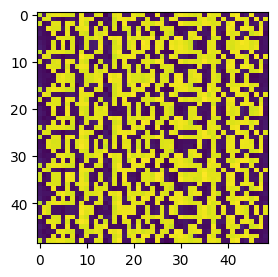

Seed set to 6




###	Version:  version_0 	###
###	Name:  symlieflat_dataflat_netTrainP_lr-1.00_seed6 	###


Loaded model from ../logs/symlieflat_dataflat_netTrainP_lr-1.00_seed6/version_0/checkpoints


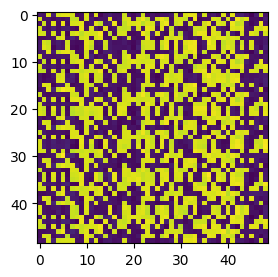

Seed set to 7




###	Version:  version_0 	###
###	Name:  symlieflat_dataflat_netTrainP_lr-1.00_seed7 	###


Loaded model from ../logs/symlieflat_dataflat_netTrainP_lr-1.00_seed7/version_0/checkpoints


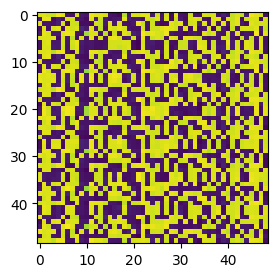

In [9]:
# lrs = torch.logspace(-7, -1, 7)
lrs = [1e-1]

seeds = torch.arange(1,8)

P_preds = {}
for seed, lr in product(seeds, lrs):

    args = parse_options(notebook=True)
    args.net = 'TrainP'

    args.train = False
    args.do_return = True
    args.version = 'version_0'

    args.lr = lr
    args.seed = seed

    args.n_splits = [10_000, 1_000, 1_000]

    model, trainer, datamodule, _ = main(args)

    # Visualize and save the predicted P matrix
    P_pred = model.net.P.data.clone()
    P_pred = model.net.normalize_P(P_pred)

    P_preds[seed.item()] = P_pred

    plt.figure(figsize = (3,3))
    plt.imshow(P_pred)
    plt.show()

In [10]:
x, y, eps = batch = next(iter(datamodule.test_dataloader()))

In [11]:
out_a, out_b = model(batch)
print('Output NOT allclose!' if not torch.allclose(out_a, out_b) else 'pass')
out_a, out_b

Output NOT allclose!


(tensor([[ 0.4676,  0.1478,  0.1669, -0.2025, -0.0783,  0.2869, -0.1566],
         [-0.2383,  0.1594, -0.0552, -0.5699,  0.0951,  0.7408, -0.5070]],
        grad_fn=<StackBackward0>),
 tensor([[ 0.4676,  0.1478,  0.1669, -0.2025, -0.0783,  0.2869, -0.1566],
         [-0.2393,  0.1612, -0.0574, -0.5665,  0.0979,  0.7444, -0.4991]],
        grad_fn=<SqueezeBackward1>))

In [7]:
seeds = [1]

nets = ['Predict-NoneP', 'Predict-CalculatedP', 'Predict-TrainedP']

for seed, net in product(seeds, nets):
    args = parse_options(notebook=True)

    args.net = net
    args.seed = seed

    if net == 'Predict-TrainedP':
        args.P_pred = P_preds[seed.item()]

    model, trainer, datamodule, _ = main(args)


Seed set to 1
/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.




###	Version:  None 	###
###	Name:  symlieflat_dataflat_netPredict-NoneP_lr-3.00_seed1 	###


Epoch 0:   0%|          | 0/200 [00:00<?, ?it/s]                           

/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


Testing DataLoader 0: 100%|██████████| 500/500 [00:00<00:00, 609.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     4.576298236846924     │
└───────────────────────────┴───────────────────────────┘

NotImplementedError: No action specified

In [2]:
data = get_data(filter = 'symlieflat')
data = get_results(data, metrics = ['test_loss'])

100%|██████████| 35/35 [03:32<00:00,  6.07s/it]


In [3]:
df = pd.DataFrame()

for k, v in data.items():
    _, _, net, _, seed, _, _ = k.split('_')
    net = net.split('-')[-1]
    seed = int(seed.replace('seed', ''))

    test_loss = v['test_loss']
    if len(test_loss) == 0:
        print(net, seed)
        test_loss = [np.nan]
    assert len(set(test_loss)) == 1, test_loss
    test_loss = test_loss[0]

    df.at[seed, net] = test_loss
df

,CalculatedP,NoneP,netTrainP,TrainedP
2,0.152836,0.175433,0.000077,0.159611
5,0.159873,0.183940,0.000039,0.158835
7,0.151323,0.155761,0.000071,0.154172
4,0.161532,0.177938,0.000075,0.167362
3,0.159184,0.155380,0.000076,0.160156
6,0.152903,0.157413,0.000141,0.152209
1,0.158360,0.180106,0.000086,0.156499
8,NaN,NaN,0.000033,NaN


In [4]:
df = df[['NoneP', 'CalculatedP', 'TrainedP']]

NameError: name 'P_preds' is not defined

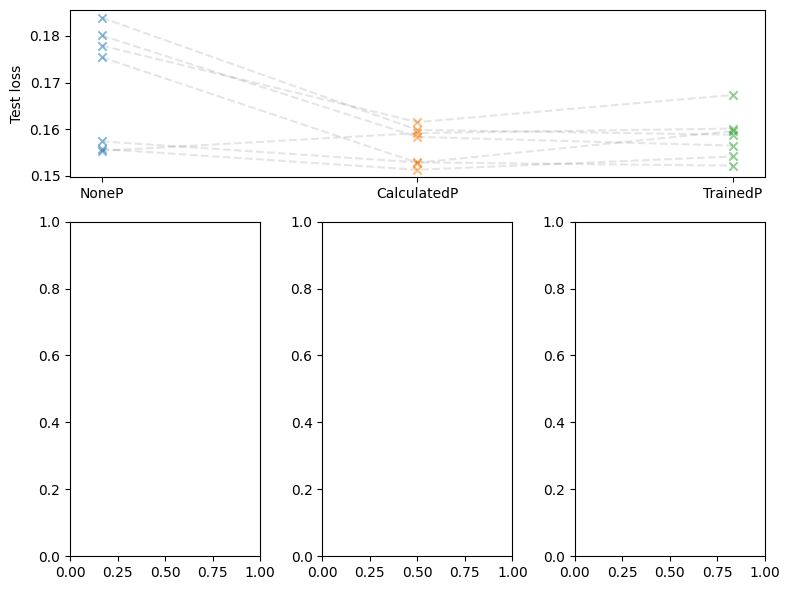

In [5]:
fig, axs = plt.subplot_mosaic("AAA;BCD", figsize = (8,6), tight_layout = True, gridspec_kw = dict(height_ratios = [0.5, 1]))

ax = axs['A']

for i, (seed, vals) in enumerate(df.iterrows()):
    ax.plot(vals, label = seed, marker = None, ls = '--', alpha = 0.1, color = 'k')

net_colors = {'NoneP': 'C0', 'CalculatedP': 'C1', 'TrainedP': 'C2'}

for i, (net, test_losses) in enumerate(df.T.iterrows()):
    vals = test_losses.values
    ax.scatter(np.full_like(vals, i), vals, alpha = 0.5, marker = 'x', color = net_colors[net])

ax.set_xticks(np.arange(len(df.T)), df.T.index)
ax.set_ylabel('Test loss')

calculated_Ps = {k: v() for k, v in CalculatedP(size=7).transform_funcs.items()}

P_none = calculated_Ps['none']
P_calculated = calculated_Ps['space_translation']
P_pred = P_preds[1]

P_plots = [P_none, P_calculated, P_pred]

for i, (P, ax_i) in enumerate(zip(P_plots, ['B', 'C', 'D'])):
    ax = axs[ax_i]
    ax.imshow(P)
    # ax.set_axis_off()
    ax.patch.set_edgecolor(list(net_colors.values())[i])

    ax.patch.set_linewidth(5)  

    # Disable ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

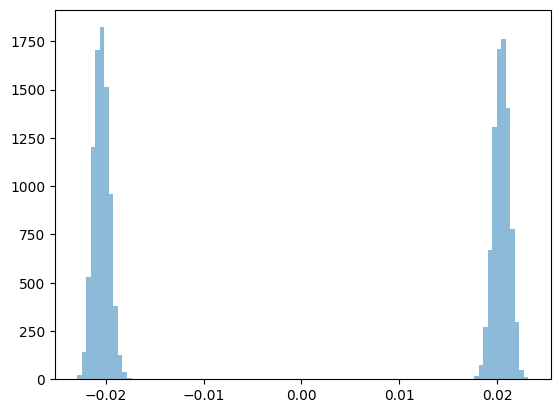

In [72]:
P_preds_tensor = torch.stack(list(P_preds.values()))

plt.hist( P_preds_tensor.numpy().flatten(), bins = 100, alpha = 0.5, label = 'Trained P')
plt.show()

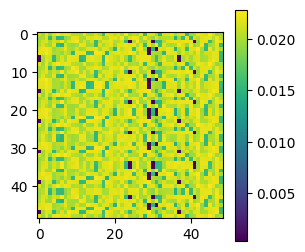

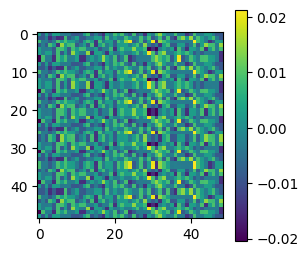

In [74]:
plt.figure(figsize = (3,3))
plt.imshow( torch.std(P_preds_tensor, dim = 0) )
plt.colorbar()
plt.show()


plt.figure(figsize = (3,3))
plt.imshow( torch.mean(P_preds_tensor, dim = 0) )
plt.colorbar()
plt.show()

In [35]:

args = parse_options(notebook=True)

args.net = 'Predict-CalculatedP'
args.seed = 1

args.train = False
args.test = False
args.version = 'version_0'
args.predict = True

model, trainer, datamodule, preds = main(args)


Seed set to 1




###	Version:  version_0 	###
###	Name:  symlieflat_dataflat_netPredict-CalculatedP_lr-3.00_seed1 	###


Loaded model from ../logs/symlieflat_dataflat_netPredict-CalculatedP_lr-3.00_seed1/version_0/checkpoints
Predicting...


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Predicting DataLoader 0: 100%|██████████| 500/500 [00:00<00:00, 1102.75it/s]


In [25]:
def stack_preds(preds):
    y_preds, y_trues = [], []
    for y_true, y_pred in preds:
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = torch.cat(y_trues)
    y_preds = torch.cat(y_preds)

    return y_trues, y_preds

In [37]:
mse_loss = F.mse_loss(y_preds, y_trues)
mse_loss.item()

0.15836013853549957

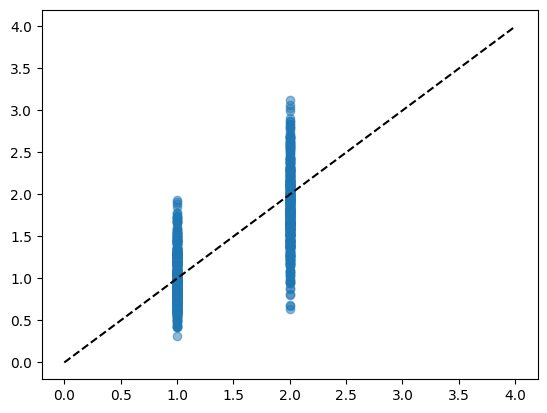

In [39]:
l = 4
plt.plot(y_trues, y_preds, 'o', alpha = 0.5)
plt.plot([0, l], [0,l], 'k--')